In [ ]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# My APIs
import my_data_frequency_conversor as dfc
import my_models as mm
import my_prompting_tool as mpt 

# Classical models
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

# TimeSeries Transformer models
## TimeGPT
from nixtla import NixtlaClient

## Moirai
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

## Chronos
from chronos import BaseChronosPipeline
import torch

# General purpose LLMs 
from huggingface_hub import login

# Utilities
from dotenv import load_dotenv
import os
load_dotenv()  # Carga el .env
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error






In [38]:
# Datasets local names
DATA_HOURS = 'DATA/ETHUSD-H1.csv'
DATA_DAYS = 'DATA/ETHUSD-D1.csv'
DATA_MONTHS = 'DATA/ETHUSD-Monthly.csv'

# Models initialization
arima_h = mm.Model('ARIMA', 0, 0, 0)
arima_d = mm.Model('ARIMA-d', 0, 0, 0)
arima_m = mm.Model('ARIMA-m', 0, 0, 0)
exp_smooth_h = mm.Model('EXPONENTIAL SMOOTHING', 0, 0, 0)
exp_smooth_d = mm.Model('EXPONENTIAL SMOOTHING', 0, 0, 0)
exp_smooth_m = mm.Model('EXPONENTIAL SMOOTHING', 0, 0, 0)
holt_h = mm.Model('HOLT', 0, 0, 0)
holt_d = mm.Model('HOLT', 0, 0, 0)
holt_m = mm.Model('HOLT', 0, 0, 0)
holt_winters_h = mm.Model('HOLT WINTERS', 0, 0, 0)
holt_winters_d = mm.Model('HOLT WINTERS', 0, 0, 0)
holt_winters_m = mm.Model('HOLT WINTERS', 0, 0, 0)
timegpt_h = mm.Model('TIMEGPT', 0, 0, 0)
timegpt_d = mm.Model('TIMEGPT', 0, 0, 0)
timegpt_m = mm.Model('TIMEGPT', 0, 0, 0)
moirai_h = mm.Model('MOIRAI', 0, 0, 0)
moirai_d = mm.Model('MOIRAI', 0, 0, 0)
moirai_m = mm.Model('MOIRAI', 0, 0, 0)
chronos_h = mm.Model('CHRONOS', 0, 0, 0)
chronos_d = mm.Model('CHRONOS', 0, 0, 0)
chronos_m = mm.Model('CHRONOS', 0, 0, 0)
gpt_h = mm.Model('GPT-H', 0, 0, 0)
gpt_d = mm.Model('GPT-D', 0, 0, 0)
gpt_m = mm.Model('GPT-M', 0, 0, 0)

# Models dictionary
models_dict = {
    'ARIMA_H': arima_h,
    'ARIMA_D': arima_d,
    'ARIMA_M': arima_m,
    'EXP_SMOOTH_H': exp_smooth_h,
    'EXP_SMOOTH_D': exp_smooth_d,
    'EXP_SMOOTH_M': exp_smooth_m,
    'HOLT_H': holt_h,
    'HOLT_D': holt_d,
    'HOLT_M': holt_m,
    'HOLT_WINTERS_H': holt_winters_h,
    'HOLT_WINTERS_D': holt_winters_d,
    'HOLT_WINTERS_M': holt_winters_m,
    'TIMEGPT_H': timegpt_h,
    'TIMEGPT_D': timegpt_d,
    'TIMEGPT_M': timegpt_m,
    'MOIRAI_H': moirai_h,
    'MOIRAI_D': moirai_d,
    'MOIRAI_M': moirai_m,
    'CHRONOS_H': chronos_h,
    'CHRONOS_D': chronos_d,
    'CHRONOS_M': chronos_m,
    'GPT_H': gpt_h,
    'GPT_D': gpt_d,
    'GPT_M': gpt_m
}


In [21]:
# Data monthly frequency preprocessing
data_months = pd.read_csv(DATA_MONTHS, delimiter=',')
train_data_months, val_data_months = dfc.split_data(data_months)
train_data_months = train_data_months.asfreq('MS')
val_data_months = val_data_months.asfreq('MS')

# Data daily frequency preprocessing
data_days = pd.read_csv(DATA_DAYS, delimiter=',')
train_data_days, val_data_days = dfc.split_data(data_days)
train_data_days = train_data_days.asfreq('d')
val_data_days = val_data_days.asfreq('d')

# Data hourly frequency preprocessing
data_hours = pd.read_csv(DATA_HOURS, delimiter=',')
train_data_hours, val_data_hours = dfc.split_data(data_hours)
train_data_hours = train_data_hours.asfreq('h')
val_data_hours = val_data_hours.asfreq('h')

In [ ]:
# Arima monthly modelling and prediction
arima_m.arima_format = dfc.convert_to_nixtla(train_data_months)
arima_m.model = StatsForecast(
    models=[AutoARIMA(season_length=1)],
    freq='MS'
)

arima_m.model.fit(arima_m.arima_format)
arima_m.forecast = arima_m.model.predict(h=12, level=[95])
print(arima_m.forecast)


   unique_id         ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0      Value 2024-01-01  2041.977347      1060.637520      3023.317174
1      Value 2024-02-01  2032.962850       750.906860      3315.018840
2      Value 2024-03-01  2025.384395       567.741214      3483.027576
3      Value 2024-04-01  2019.013215       449.070571      3588.955858
4      Value 2024-05-01  2013.656986       368.962716      3658.351255
5      Value 2024-06-01  2009.154023       313.614072      3704.693975
6      Value 2024-07-01  2005.368399       274.793017      3735.943781
7      Value 2024-08-01  2002.185838       247.270269      3757.101406
8      Value 2024-09-01  1999.510270       227.593427      3771.427112
9      Value 2024-10-01  1997.260929       213.425816      3781.096043
10     Value 2024-11-01  1995.369917       203.159123      3787.580710
11     Value 2024-12-01  1993.780149       195.673203      3791.887095


In [24]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = arima_m.forecast.get('AutoARIMA').values

# Calculate metrics
arima_m.mse = mean_squared_error(y_true, y_pred)
arima_m.mae = mean_absolute_error(y_true, y_pred)
arima_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"ARIMA - MSE: {arima_m.mse}, MAE: {arima_m.mae}, MAPE: {arima_m.mape}")

ARIMA - MSE: 1338586.430075248, MAE: 1020.4563068645417, MAPE: 0.3138722235735264


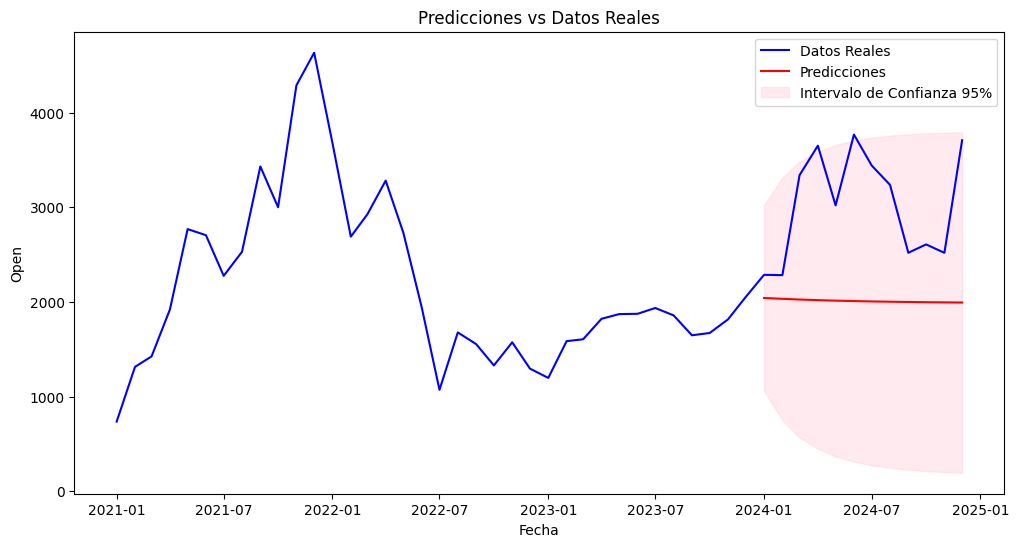

In [25]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_months.reset_index().iloc[:, :2]
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_months.reset_index().iloc[:, :2]
val_df.columns = ['ds', 'y']
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_m.forecast['ds'], arima_m.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_m.forecast['ds'],
    arima_m.forecast['AutoARIMA-lo-95'],
    arima_m.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Open')

# Mostrar la gráfica
plt.show()

In [ ]:
# Arima daily modelling and prediction
arima_d.arima_format = dfc.convert_to_nixtla(train_data_days)
arima_d.model = StatsForecast(
    models=[AutoARIMA(season_length=1)],
    freq='D'
)
'''
season_length=7:Se asume que hay un patrón semanal en los datos diarios. 
Si no es el caso, se puede cambiar a 1 (sin estacionalidad) o 365 (estacionalidad anual).
'''
arima_d.model.fit(arima_d.arima_format)
arima_d.forecast = arima_d.model.predict(h=366, level=[95])
print(arima_d.forecast)

    unique_id         ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0       Value 2024-01-01  2294.515294      2089.583156      2499.447431
1       Value 2024-01-02  2294.468710      2017.441106      2571.496314
2       Value 2024-01-03  2294.472921      1959.631755      2629.314088
3       Value 2024-01-04  2294.472541      1910.498598      2678.446483
4       Value 2024-01-05  2294.472575      1866.969925      2721.975225
..        ...        ...          ...              ...              ...
361     Value 2024-12-27  2294.472572     -1282.222586      5871.167730
362     Value 2024-12-28  2294.472572     -1287.156995      5876.102139
363     Value 2024-12-29  2294.472572     -1292.084615      5881.029759
364     Value 2024-12-30  2294.472572     -1297.005474      5885.950618
365     Value 2024-12-31  2294.472572     -1301.919600      5890.864744

[366 rows x 5 columns]


In [28]:
# Get actual values and predictions as np arrays
y_true = val_data_days.get('y').values
y_pred = arima_d.forecast.get('AutoARIMA').values

# Calculate metrics
arima_d.mse = mean_squared_error(y_true, y_pred)
arima_d.mae = mean_absolute_error(y_true, y_pred)
arima_d.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"ARIMA - MSE: {arima_d.mse}, MAE: {arima_d.mae}, MAPE: {arima_d.mape}")

ARIMA - MSE: 822046.3553982835, MAE: 753.4379975380599, MAPE: 0.2259071030012996


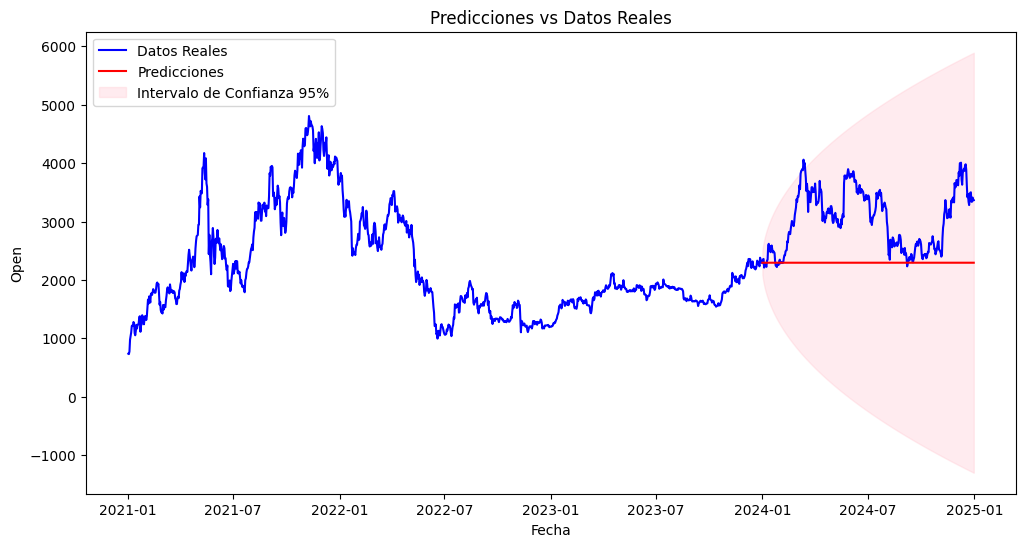

In [29]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_days.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_days.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
val_df.columns = ['ds', 'y']  # Renombrar columnas
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_d.forecast['ds'], arima_d.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_d.forecast['ds'],
    arima_d.forecast['AutoARIMA-lo-95'],
    arima_d.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Open')

# Mostrar la gráfica
plt.show()

In [ ]:
# Arima hourly modelling and prediction
arima_h.arima_format = dfc.convert_to_nixtla(train_data_hours)
arima_h.model = StatsForecast(
    models=[AutoARIMA(season_length=24)],
    freq='H'
)
'''
season_length=24: Se asume que hay un patrón diario en los datos horarios.
Si no es el caso, se puede cambiar a 1 (sin estacionalidad) o 168 (estacionalidad semanal).
'''
arima_h.model.fit(arima_h.arima_format)
arima_h.forecast = arima_h.model.predict(h=24*366, level=[95])
print(arima_h.forecast.head())

In [ ]:
# Get actual values and predictions as np arrays
y_true = val_data_hours.get('y').values
y_pred = arima_h.forecast.get('AutoARIMA').values

# Calculate metrics
arima_h.mse = mean_squared_error(y_true, y_pred)
arima_h.mae = mean_absolute_error(y_true, y_pred)
arima_h.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"ARIMA - MSE: {arima_h.mse}, MAE: {arima_h.mae}, MAPE: {arima_h.mape}")

In [ ]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_hours.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_hours.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
val_df.columns = ['ds', 'y']  # Renombrar columnas
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_h.forecast['ds'], arima_h.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_h.forecast['ds'],
    arima_h.forecast['AutoARIMA-lo-95'],
    arima_h.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Open')

# Mostrar la gráfica
plt.show()

In [30]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_m.model = SimpleExpSmoothing(train_data_months).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_m.optimal_alpha = exp_smooth_m.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_m.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_m.forecast = exp_smooth_m.model.forecast(steps=12)
exp_smooth_m.forecast


Alpha óptimo: 0.9950


2024-01-01    2051.5119
2024-02-01    2051.5119
2024-03-01    2051.5119
2024-04-01    2051.5119
2024-05-01    2051.5119
2024-06-01    2051.5119
2024-07-01    2051.5119
2024-08-01    2051.5119
2024-09-01    2051.5119
2024-10-01    2051.5119
2024-11-01    2051.5119
2024-12-01    2051.5119
Freq: MS, dtype: float64

In [ ]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = exp_smooth_m.forecast.values

# Calculate metrics
exp_smooth_m.mse = mean_squared_error(y_true, y_pred)
exp_smooth_m.mae = mean_absolute_error(y_true, y_pred)
exp_smooth_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Exponential Smoothing - MSE: {exp_smooth_m.mse}, MAE: {exp_smooth_m.mae}, MAPE: {exp_smooth_m.mape}")

In [ ]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_d.model = SimpleExpSmoothing(train_data_days).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_d.optimal_alpha = exp_smooth_d.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_d.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_d.forecast = exp_smooth_d.model.forecast(steps=366)
exp_smooth_d.forecast

In [ ]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_h.model = SimpleExpSmoothing(train_data_hours).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_h.optimal_alpha = exp_smooth_h.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_h.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_h.forecast = exp_smooth_h.model.forecast(steps=366*24)
exp_smooth_h.forecast

In [ ]:
holt_m.model = Holt(train_data_months).fit(optimized=True)
holt_m.optimal_alpha = holt_m.model.model.params["smoothing_level"]
holt_m.optimal_beta = holt_m.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_m.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_m.optimal_beta:.4f}")
holt_m.forecast = holt_m.model.forecast(steps=12)
holt_m.forecast

In [ ]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = holt_m.forecast.values

# Calculate metrics
holt_m.mse = mean_squared_error(y_true, y_pred)
holt_m.mae = mean_absolute_error(y_true, y_pred)
holt_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Holt Winter - MSE: {holt_m.mse}, MAE: {holt_m.mae}, MAPE: {holt_m.mape}")

In [ ]:
holt_d.model = Holt(train_data_days).fit(optimized=True)
holt_d.optimal_alpha = holt_d.model.model.params["smoothing_level"]
holt_d.optimal_beta = holt_d.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_d.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_d.optimal_beta:.4f}")
holt_d.forecast = holt_d.model.forecast(steps=366)
holt_d.forecast

In [ ]:
holt_h.model = Holt(train_data_hours).fit(optimized=True)
holt_h.optimal_alpha = holt_h.model.model.params["smoothing_level"]
holt_h.optimal_beta = holt_h.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_h.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_h.optimal_beta:.4f}")
holt_h.forecast = holt_h.model.forecast(steps=366*24)
holt_h.forecast

In [ ]:
# Ajustar el modelo con cálculo óptimo de alpha
holt_winters_m.model = ExponentialSmoothing(train_data_months, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_m.optimal_params = holt_winters_m.model.params
print(f"Parámetros óptimos: {holt_winters_m.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_m.forecast = holt_winters_m.model.forecast(steps=12)
holt_winters_m.forecast

In [ ]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = holt_winters_m.forecast.values

# Calculate metrics
holt_winters_m.mse = mean_squared_error(y_true, y_pred)
holt_winters_m.mae = mean_absolute_error(y_true, y_pred)
holt_winters_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Holt Winter - MSE: {holt_winters_m.mse}, MAE: {holt_winters_m.mae}, MAPE: {holt_winters_m.mape}")

In [ ]:
# Ajustar el modelo con cálculo óptimo de alpha, seasonal period de 7 para intentar calcular una ciclidad semanal
holt_winters_d.model = ExponentialSmoothing(train_data_days, trend='add', seasonal='add', seasonal_periods=7).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_d.optimal_params = holt_winters_d.model.params
print(f"Parámetros óptimos: {holt_winters_d.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_d.forecast = holt_winters_d.model.forecast(steps=366)
holt_winters_d.forecast


In [ ]:
# Ajustar el modelo con cálculo óptimo de alpha, seasonal period de 24 para intentar calcular una ciclidad diaria
holt_winters_h.model = ExponentialSmoothing(train_data_hours, trend='add', seasonal='add', seasonal_periods=24).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_h.optimal_params = holt_winters_h.model.params
print(f"Parámetros óptimos: {holt_winters_h.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_h.forecast = holt_winters_h.model.forecast(steps=366*24)
holt_winters_h.forecast

In [4]:
# TimeGPT Api Key and Client validation
my_api_key = os.getenv("MY_NIXTLA_API_KEY")
nixtla_client = NixtlaClient(
    api_key = my_api_key
)
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

In [31]:
# TimeGPT monthly prediction
train_data_months_nixtla = dfc.convert_to_nixtla(train_data_months)
timegpt_m.predictions = nixtla_client.forecast(
    train_data_months_nixtla,
    h=12
)


'''timegpt_d.predictions = nixtla_client.predict(
    df=train_data_days,
    horizon=366,
    time_col='DateTime',
    target_col='Open',
)

timegpt_h.predictions = nixtla_client.predict(
    df=train_data_hours,
    horizon=366*24,
    time_col='DateTime',
    target_col='Open',
)'''


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


"timegpt_d.predictions = nixtla_client.predict(\n    df=train_data_days,\n    horizon=366,\n    time_col='DateTime',\n    target_col='Open',\n)\n\ntimegpt_h.predictions = nixtla_client.predict(\n    df=train_data_hours,\n    horizon=366*24,\n    time_col='DateTime',\n    target_col='Open',\n)"

In [32]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = timegpt_m.predictions.get('TimeGPT').values

# Calculate metrics
timegpt_m.mse = mean_squared_error(y_true, y_pred)
timegpt_m.mae = mean_absolute_error(y_true, y_pred)
timegpt_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Time GPT - MSE: {timegpt_m.mse}, MAE: {timegpt_m.mae}, MAPE: {timegpt_m.mape}")

Time GPT - MSE: 1203824.7001717165, MAE: 958.0057166666666, MAPE: 0.293421838215491


In [ ]:
#!git clone https://github.com/SalesforceAIResearch/uni2ts/
%pip install uni2ts

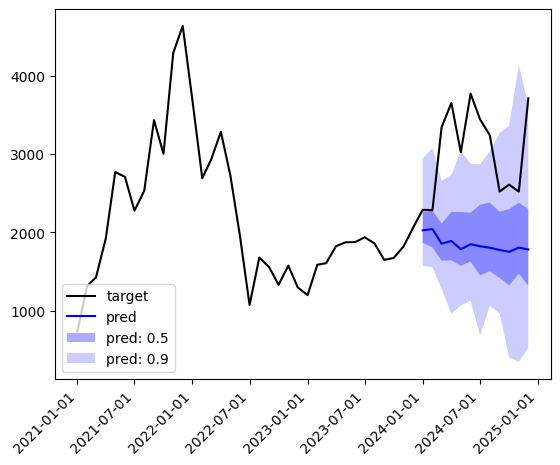

In [39]:
# Moirai monthly prediction
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 12  # prediction length: any positive integer
CTX = 12*3  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 12  # test set length: any positive integer

# Data transformation to fit Moirai input requirements
df = dfc.convert_to_moirai(data_months)
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
moirai_m.predictions = next(forecast_it)

plot_single(
    inp, 
    label, 
    moirai_m.predictions, 
    context_length=200,
    name="pred",
    show_label=True,
)
plt.show()


In [46]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = moirai_m.predictions.quantile(0.5) 

# Calculate metrics
moirai_m.mse = mean_squared_error(y_true, y_pred)
moirai_m.mae = mean_absolute_error(y_true, y_pred)
moirai_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Moirai - MSE: {moirai_m.mse}, MAE: {moirai_m.mae}, MAPE: {moirai_m.mape}")

Moirai - MSE: 1738422.8084758616, MAE: 1184.2288228352866, MAPE: 0.36750970234664365


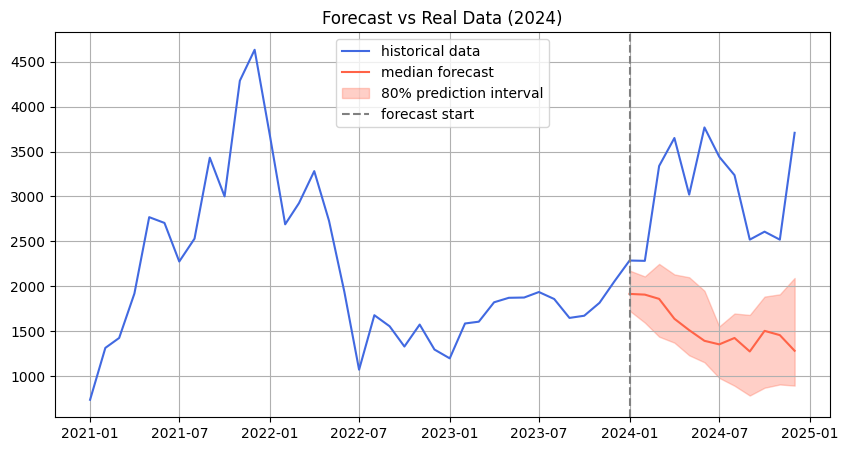

In [50]:
#%pip install chronos-forecasting
# Chronos monthly prediction
# Cargar modelo
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # usa "amazon/chronos-bolt-small" para Chronos-Bolt
    device_map="cpu",
    dtype=torch.bfloat16,
)

# Convertir datos (dfc y data_months deben estar definidos antes)
df = dfc.convert_to_moirai(data_months)

# --- 1. Usar solo datos hasta 2023 para entrenar el contexto ---
df_context = df[df.index < "2024-01-01"]

# Predecir 12 meses (todo 2024)
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_context["y"].values, dtype=torch.float32).unsqueeze(0),
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
)

# --- 2. Construir índice de forecast para 2024 ---
forecast_index = pd.date_range(start="2024-01-01", periods=12, freq="MS")

low, chronos_m.forecast, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# --- 3. Plotear ---
plt.figure(figsize=(10, 5))

# Datos históricos completos (incluye 2024 real)
plt.plot(df.index, df["y"], color="royalblue", label="historical data")

# Predicción (para 2024)
plt.plot(forecast_index, chronos_m.forecast, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.axvline(pd.Timestamp("2024-01-01"), color="gray", linestyle="--", label="forecast start")

plt.legend()
plt.grid()
plt.title("Forecast vs Real Data (2024)")
plt.show()



In [51]:
# Get actual values and predictions as np arrays
y_true = val_data_months.get('y').values
y_pred = chronos_m.forecast.numpy()

# Calculate metrics
chronos_m.mse = mean_squared_error(y_true, y_pred)
chronos_m.mae = mean_absolute_error(y_true, y_pred)
chronos_m.mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Chronos - MSE: {chronos_m.mse}, MAE: {chronos_m.mae}, MAPE: {chronos_m.mape}")

Chronos - MSE: 2656367.031150206, MAE: 1488.7478149414064, MAPE: 0.4677208952535148


In [ ]:
# Convertir la serie temporal a lenguaje natural
desp = mpt.paraphrase_initial(gpt_m.name)
train_lan = mpt.paraphrase_seq2lan(train_data_months, desp)

# Realizar la predicción para los próximos 12 meses (1 año)
steps = 12  # Número de meses a predecir
model_name = 'gpt-4o-mini'  
predicted_lan = mpt.paraphrasing_predict_llm(desp, train_lan, steps, model_name)
print(predicted_lan)
# Convertir la predicción en lenguaje natural de vuelta a una serie temporal
predicted_series = mpt.recover_lan2seq(predicted_lan)

# Mostrar la serie temporal predicha
print(predicted_series)

In [ ]:
# Login to Hugging Face to use General Purpose LLM models
HF_TOKEN = os.getenv("HF_TOKEN")
login(token=HF_TOKEN)


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,   # usar float32 para CPU
    device_map="cpu"
)

inputs = tokenizer("¿Qué es el aprendizaje automático?", return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=200)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
